In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Algorithms
from sklearn import ensemble, linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier

# permutation_importance
from sklearn.inspection import permutation_importance

from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_sample_weight

In [2]:
# Import data
data = pd.read_csv('year_train.csv')
test_in = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder/y_test_data.csv')
train_in = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder/year_train_data.csv')
test_out = pd.read_csv('C:/Users/94018/Documents/BA886-7(2)/New folder (3)/year_outsample.csv')

In [4]:
# Define the importance function for feature selection
def spearman(x):
    return abs(stats.spearmanr(x,y)[0])
def spear_imp(data):
    spearman_importance = data.apply(spearman).sort_values()
    return spearman_importance

In [5]:
# Loading downsample data
X = data.drop(columns=['year','pol_id', 'STATE_x','ZIP5_x','ZIP4_x','no_hit_x','Unnamed: 0','Unnamed: 0.1','STATE_y','ZIP5_y','ZIP4_y','no_hit_y'])
y = data['no_hit_x']
importance = spear_imp(X)
X_n = X.drop(columns=importance.index[0:400])

In [6]:
#loading original test set
X_in_test = test_in.drop(columns=['year','pol_id', 'STATE','ZIP5','ZIP4','no_hit']).drop(columns=importance.index[0:400])
y_in_act = test_in['no_hit']

In [7]:
#loading original train set
X_in_train = train_in.drop(columns=['year','pol_id', 'STATE','ZIP5','ZIP4','no_hit']).drop(columns=importance.index[0:400])
y_in_train = train_in['no_hit']

In [8]:
#loading outsample test set
X_out_test = test_out.drop(columns=['no_hit','Unnamed: 0']).drop(columns=importance.index[0:400])
y_out_act = test_out['no_hit']

In [9]:
best_params = [{'ridgeclassifier__solver': 'auto',
  'ridgeclassifier__fit_intercept': True,
  'ridgeclassifier__class_weight': None,
  'ridgeclassifier__alpha': 0.01},
 {'randomforestclassifier__n_estimators': 95,
  'randomforestclassifier__min_samples_split': 3,
  'randomforestclassifier__min_samples_leaf': 1,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__max_depth': 28,
  'randomforestclassifier__class_weight': 'balanced'},
 {'extratrees__warm_start': False,
  'extratrees__n_estimators': 500,
  'extratrees__min_samples_split': 5,
  'extratrees__min_samples_leaf': 2,
  'extratrees__max_features': 'auto',
  'extratrees__max_depth': None,
  'extratrees__class_weight': None},
 {'xgbclassifier__subsample': 0.7000000000000002,
  'xgbclassifier__sampling_method': 'uniform',
  'xgbclassifier__max_depth': 26,
  'xgbclassifier__gamma': 3,
  'xgbclassifier__eta': 0.1,
  'xgbclassifier__booster': 'gbtree'}]

In [10]:
model = xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                          sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                          max_depth=best_params[3].get('xgbclassifier__max_depth'),
                          gamma=best_params[3].get('xgbclassifier__gamma'),
                          eta=best_params[3].get('xgbclassifier__eta'),
                          booster=best_params[3].get('xgbclassifier__booster'))

In [11]:
w = np.bincount(y_in_train) / np.bincount(y)
w = {0:w[0],1:1}
w = compute_sample_weight(w,y)

## insample xgb

In [13]:
# fit the model and get probability for each data point
# model.fit(X_n,y,sample_weight=w)
# model.fit(X_n,y)
model.load_model('downsample.model')
p_in = model.predict_proba(X_in_test)

C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [14]:
# model.save_model('down_xgb.model')

In [15]:
positive,negative = list(),list()
for i in p_in:
    positive.append(i[1])
    negative.append(i[0])

In [16]:
lift_in = pd.DataFrame()
lift_in['actual'] = y_in_act
lift_in['positive'] = positive
lift_in['negative'] = negative

In [17]:
# lift_in.to_csv('insample_xgb.csv')

In [18]:
# lift_in = pd.read_csv('insample_xgb.csv')

In [19]:
lift_in = lift_in.sort_values(by = 'positive')

In [20]:
# evaluate the models and store results
act,pb = list(),list()
n = len(lift_in)
n_group = 40
for i in range(n_group):
    a = np.mean(lift_in['actual'][int(n*i/n_group):int(n*(i+1)/n_group)])
    b = np.mean(lift_in['positive'][int(n*i/n_group):int(n*(i+1)/n_group)])
    act.append(a)
    pb.append(b)

In [21]:
sample_ratio_of_0 = (np.bincount(y) / np.bincount(y_in_train))[0]
estimated_logit = pd.Series(pb).agg(lambda x: math.log(x/(1-x)))
orig_logit = estimated_logit + math.log(sample_ratio_of_0)
orig_level_prob = orig_logit.agg(math.exp).agg(lambda x: x/(1+x))
lift_chart_in = pd.DataFrame({'act':act,'prob':pb,'orig_level_prob':orig_level_prob})
lift_chart_in

,act,prob,orig_level_prob
0,0.019789,0.020688,0.002053
1,0.017798,0.030521,0.003057
2,0.017139,0.037468,0.003777
3,0.014512,0.043879,0.004450
4,0.016480,0.050023,0.005103
5,0.019776,0.056140,0.005760
6,0.027686,0.062388,0.006439
7,0.021108,0.068987,0.007165
8,0.025049,0.075803,0.007925
9,0.029664,0.082773,0.008713


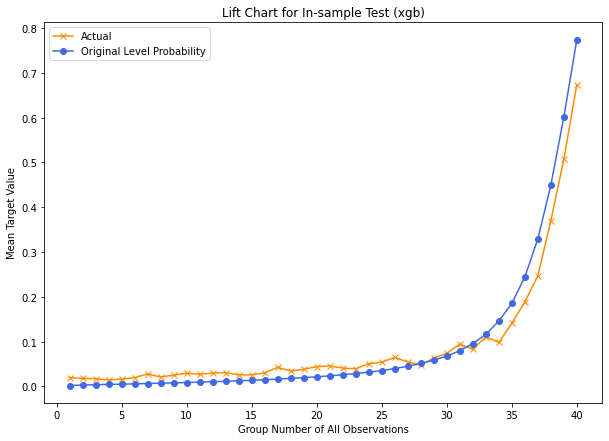

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(range(n_group+1)[1:], lift_chart_in['act'], label='Actual', color='darkorange', marker='x')
# plt.plot(range(n_group+1)[1:], lift_chart_in['prob'], label='Probability', color='royalblue', marker='D')
plt.plot(range(n_group+1)[1:], lift_chart_in['orig_level_prob'], label='Original Level Probability', color='royalblue', marker='o')
plt.title('Lift Chart for In-sample Test (xgb)')
plt.xlabel('Group Number of All Observations')
plt.ylabel('Mean Target Value')
plt.legend()
plt.show()

## outsample xgb

In [113]:
model = xgb.XGBClassifier(subsample=best_params[3].get('xgbclassifier__subsample'),
                          sampling_method=best_params[3].get('xgbclassifier__sampling_method'),
                          max_depth=best_params[3].get('xgbclassifier__max_depth'),
                          gamma=best_params[3].get('xgbclassifier__gamma'),
                          eta=best_params[3].get('xgbclassifier__eta'),
                          booster=best_params[3].get('xgbclassifier__booster'))

In [137]:
# fit the model and get probability for each data point
# model.fit(X_n,y,sample_weight=w)
model.fit(X_n,y)
p_out = model.predict_proba(X_out_test)

C:\Users\94018\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [117]:
positive_o,negative_o = list(),list()
for i in p_out:
    positive_o.append(i[1])
    negative_o.append(i[0])

In [118]:
lift_out = pd.DataFrame()
lift_out['actual_o'] = y_out_act
lift_out['positive_o'] = positive_o
lift_out['negative_o'] = negative_o

In [119]:
# lift_out.to_csv('outsample_xgb.csv')

In [120]:
# lift_out = pd.read_csv('outsample_xgb.csv')

In [121]:
lift_out = lift_out.sort_values(by = 'positive_o')

In [122]:
# evaluate the models and store results
act_o,pb_o = list(),list()
n = len(lift_out)
n_group_o = 40
for i in range(n_group_o):
    a = np.mean(lift_out['actual_o'][int(n*i/n_group_o):int(n*(i+1)/n_group_o)])
    b = np.mean(lift_out['positive_o'][int(n*i/n_group_o):int(n*(i+1)/n_group_o)])
    act_o.append(a)
    pb_o.append(b)

In [123]:
sample_ratio_of_0 = (np.bincount(y) / np.bincount(y_in_train))[0]
estimated_logit = pd.Series(pb_o).agg(lambda x: math.log(x/(1-x)))
orig_logit = estimated_logit + math.log(sample_ratio_of_0)
orig_level_prob = orig_logit.agg(math.exp).agg(lambda x: x/(1+x))
lift_chart_out = pd.DataFrame({'act_o':act_o,'prob_o':pb_o,'orig_level_prob_o':orig_level_prob})
lift_chart_out

,act_o,prob_o,orig_level_prob_o
0,0.050489,0.027796,0.002777
1,0.043974,0.040467,0.004091
2,0.048046,0.049656,0.005063
3,0.049267,0.057767,0.005936
4,0.059422,0.065635,0.006795
5,0.057818,0.073427,0.007659
6,0.055375,0.081270,0.008542
7,0.054153,0.089418,0.009474
8,0.060668,0.097809,0.010449
9,0.058201,0.106485,0.011474


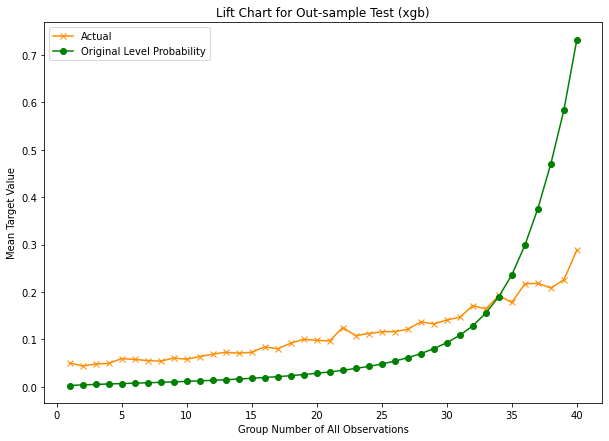

In [125]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(range(n_group_o+1)[1:], lift_chart_out['act_o'], label='Actual', color='darkorange', marker='x')
# plt.plot(range(n_group_o+1)[1:], lift_chart_out['prob_o'], label='Probability', color='royalblue', marker='D')
plt.plot(range(n_group+1)[1:], lift_chart_out['orig_level_prob_o'], label='Original Level Probability', color='green', marker='o')
plt.title('Lift Chart for Out-sample Test (xgb)')
plt.xlabel('Group Number of All Observations')
plt.ylabel('Mean Target Value')
plt.legend()
plt.show()

## AUC scores

In [24]:
test_set = [X_in_train,X_in_test,X_out_test]
label_set = [y_in_train,y_in_act,y_out_act]
AUC = pd.DataFrame()
L,P = list(),list()
for i,j in zip(test_set,label_set):
    a = model.predict(i)
    b = model.predict_proba(i)
    L.append(roc_auc_score(j,a))
    P.append(roc_auc_score(j,b[:,1]))
AUC['label_auc'] = L
AUC['proba_auc'] = P
AUC

C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,label_auc,proba_auc
0,0.918504,0.971505
1,0.747127,0.814890
2,0.611430,0.660226


In [139]:
# model.save_model('downsample_weighted.model')

In [25]:
n=len(y_in_act)
np.mean(model.predict(X_in_test)[int(n*9/10):int(n*(10)/10)])

C:\Users\94018\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.5477171583978903